In [15]:
import matplotlib.pyplot as plt
from strategies import SimpleRSIStrategy
from volume_based_indicator import *

# Initial settings
transaction_currency =  "BTC" #""ETH"
counter_currency = "USDT" #""BTC"
end_time = 1526637600
start_time = end_time - 60 * 60 * 24 * 60
horizon = Horizon.short
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# fill kwargs structure, needed later
kwargs = {}
kwargs['source'] = source
kwargs['transaction_currency'] = transaction_currency
kwargs['counter_currency'] = counter_currency
kwargs['start_time'] = start_time
kwargs['end_time'] = end_time
kwargs['horizon'] = horizon

# Load price and volume data and calculate average prices and volumes
prices_df = get_prices_in_range(start_time, end_time, transaction_currency, counter_currency, source)
prices_df.price /= 1E8

volumes_df = get_volumes_in_range(start_time, end_time, transaction_currency, counter_currency, source)
volumes_df.volume /= 1E4 #5 # scaling for visualization

sma_price = talib.SMA(np.array(prices_df.price, dtype=float), timeperiod=AVERAGING_PERIOD)
sma_volume = talib.SMA(np.array(volumes_df.volume, dtype=float), timeperiod=AVERAGING_PERIOD)

prices_df['average_price'] = pd.Series(sma_price, index=prices_df.index)
volumes_df['average_volume'] = pd.Series(sma_volume, index=volumes_df.index)
price_volume_df = prices_df.join(volumes_df)

# Convert indexes to datetime
prices_df.index = pd.to_datetime(prices_df.index, unit='s')
volumes_df.index = pd.to_datetime(volumes_df.index, unit='s')
price_volume_df.index = pd.to_datetime(price_volume_df.index, unit='s')


In [16]:
# First test of a VBI-based strategy
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, 0,0, 
                                                                    buy_only_on_first_cross=True, sell_strategy=None, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)

In [17]:
# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-04-01 18:28:38  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000144 BTC 	 (1 BTC = 6939.68615028 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-04-01 18:28:38 rsi_value=0
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->          1.10 USDT 	 currency_balance ->     -0.000144 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-04-18 04:59:19  	 OrderType.BUY    	 cash_balance ->         -1.10 USDT 	 currency_balance ->      0.000136 BTC 	 (1 BTC = 8120.63953069 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=H

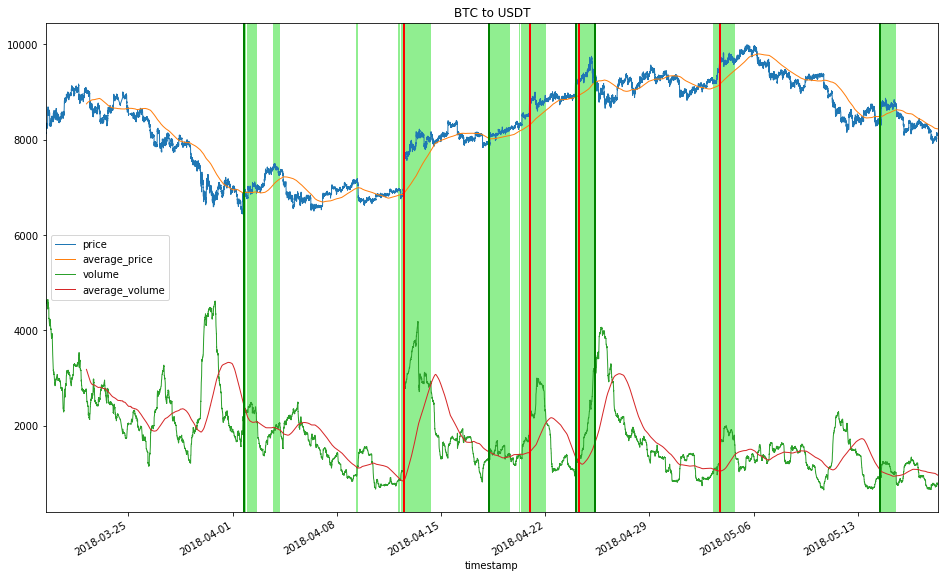

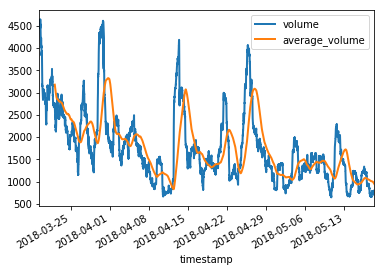

In [18]:
plot_results(price_volume_df, volumes_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)



In [1]:
# Let's try another threshold
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, 0.02, 0.02, 
                                                                    buy_only_on_first_cross=True, sell_strategy=None, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)


# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

# Plot trades
plot_results(price_volume_df, volumes_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)


NameError: name 'build_strategy' is not defined

In [20]:
overbought_threshold = 95
oversold_threshold = 25
sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                  overbought_threshold, oversold_threshold, 
                                  transaction_currency, "RSI", source)
profit_df = calculate_profits(price_volume_df, start_cash, start_crypto, sell_strategy, **kwargs)

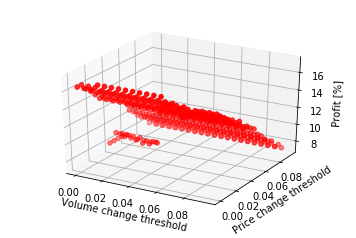

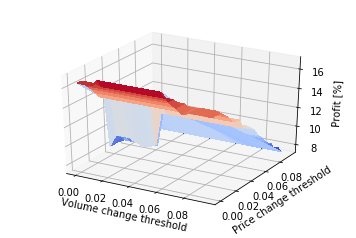

In [21]:
plot_profit_df(profit_df)

In [22]:
def write_to_excel(df, path):
    writer = pd.ExcelWriter(path)
    df.to_excel(writer,"Results")
    writer.save()

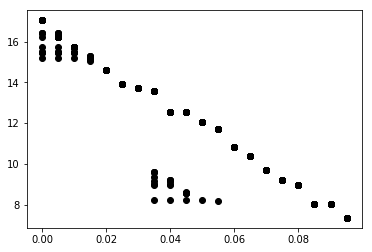

In [23]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');

In [24]:
# Find best performing parameters
sorted_by_profit = profit_df.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent
200,0.050,0.000,17.048724
240,0.060,0.000,17.048724
220,0.055,0.000,17.048724
180,0.045,0.000,17.048724
160,0.040,0.000,17.048724
140,0.035,0.000,17.048724
120,0.030,0.000,17.048724
100,0.025,0.000,17.048724
80,0.020,0.000,17.048724
60,0.015,0.000,17.048724


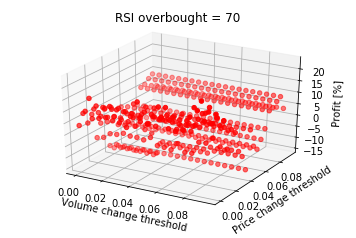

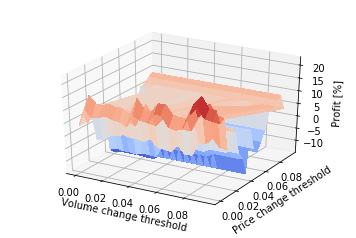

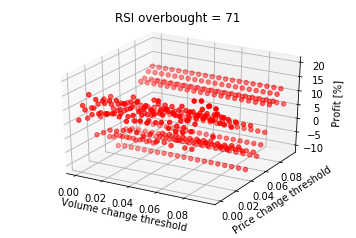

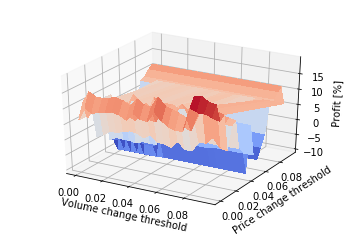

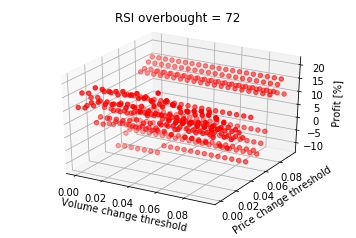

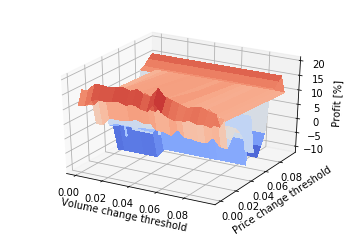

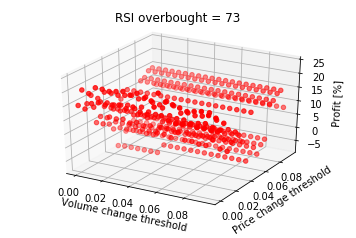

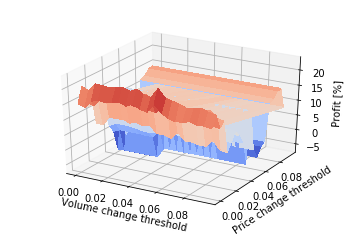

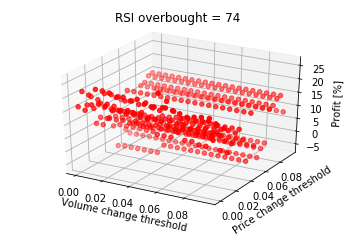

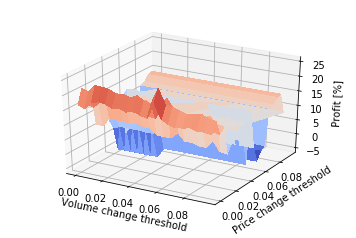

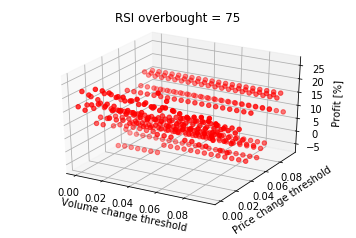

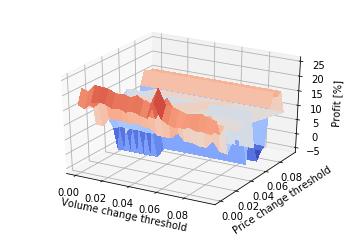

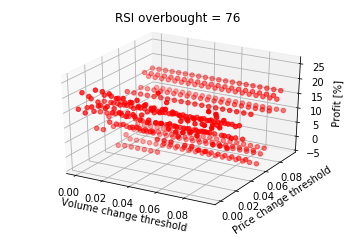

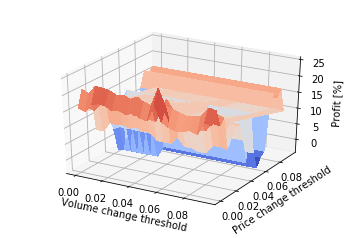

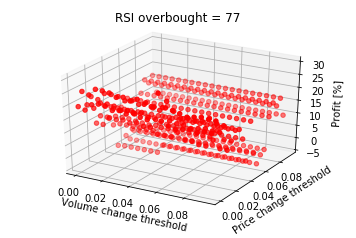

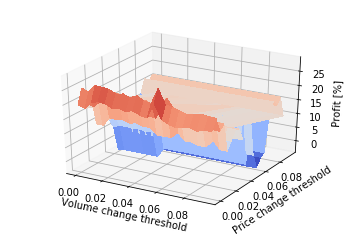

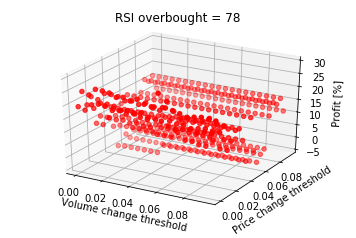

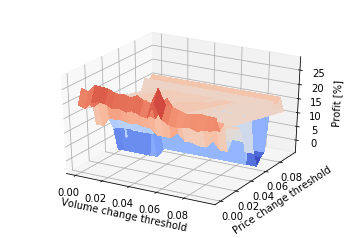

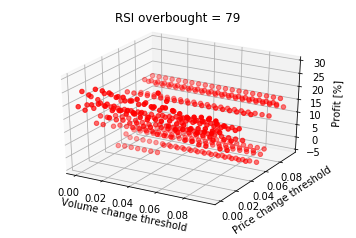

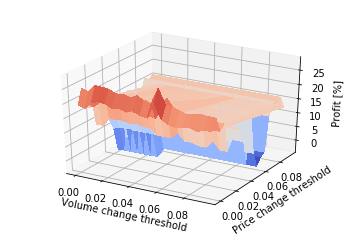

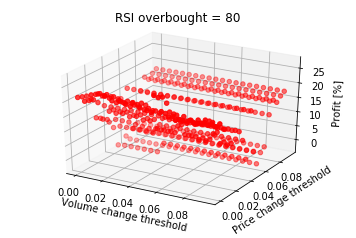

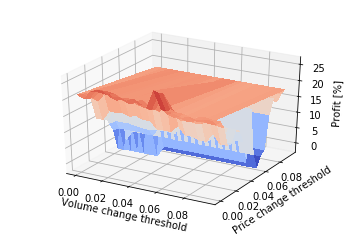

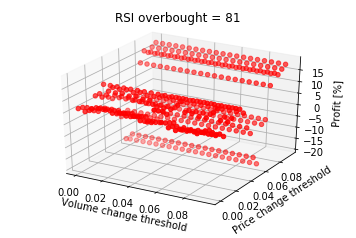

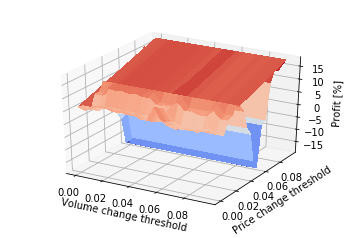

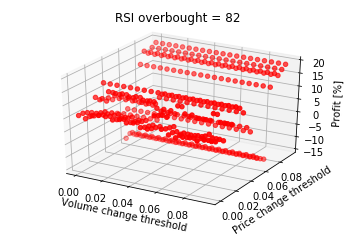

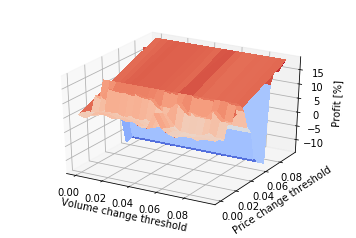

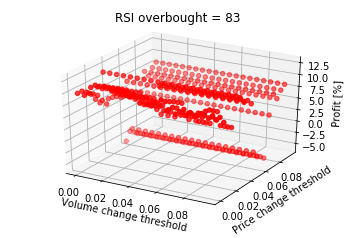

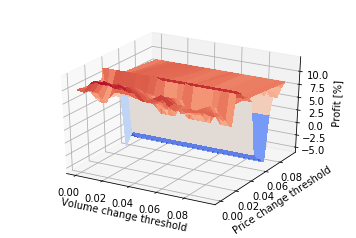

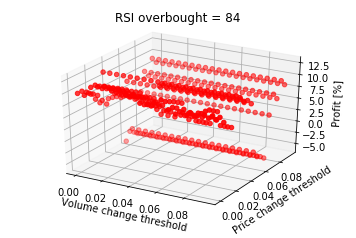

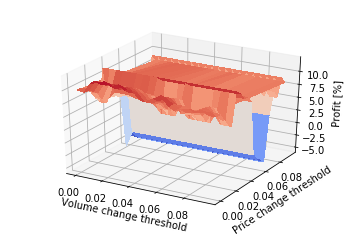

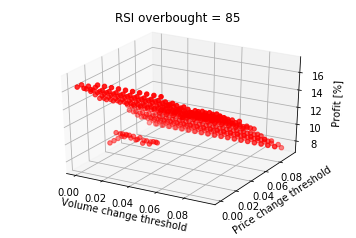

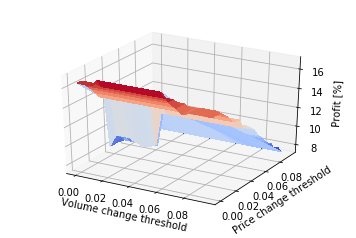

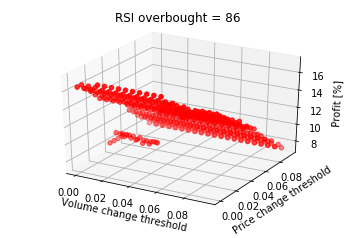

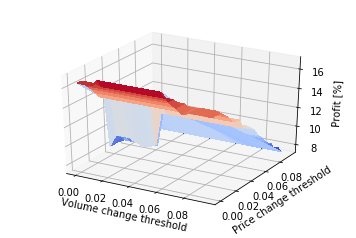

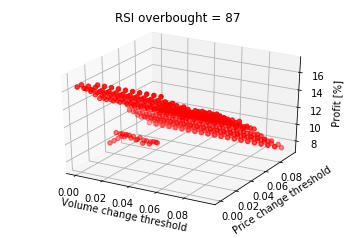

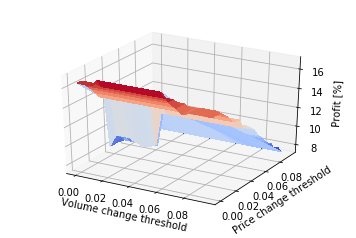

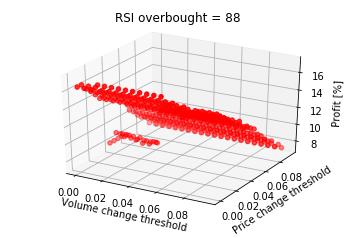

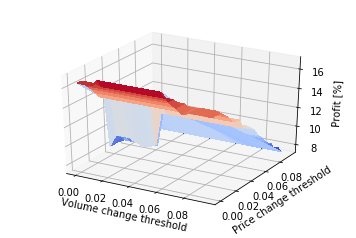

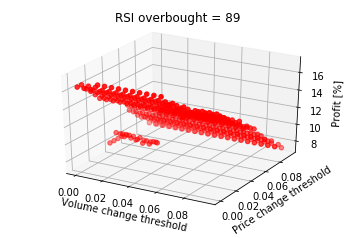

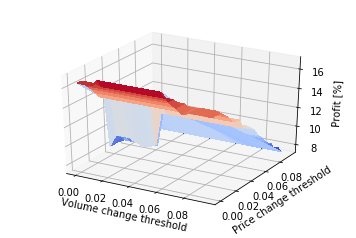

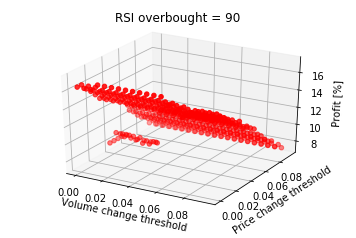

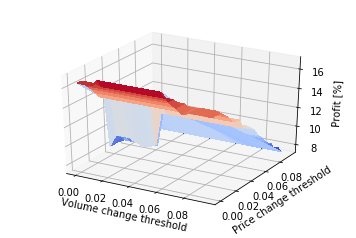

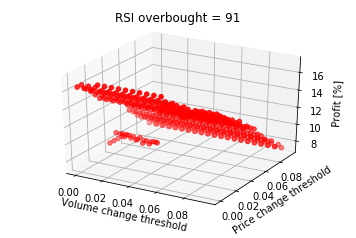

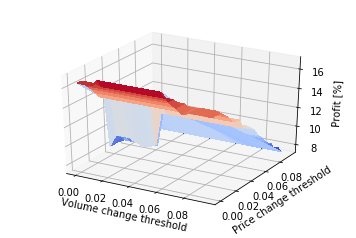

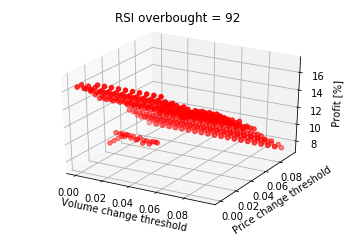

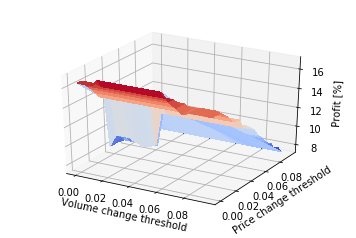

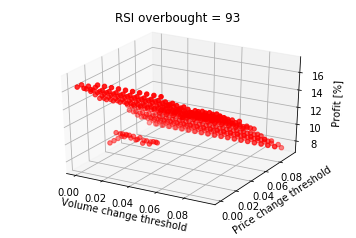

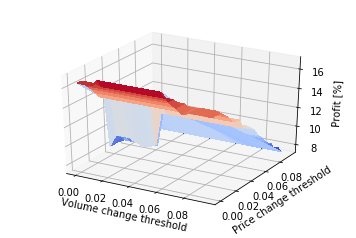

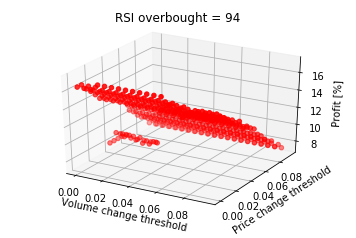

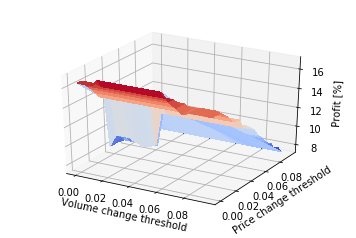

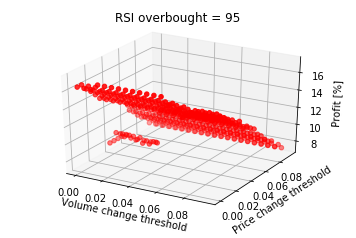

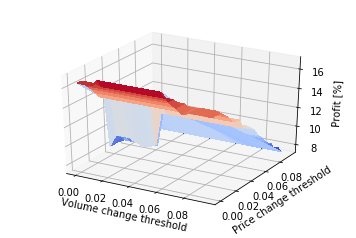

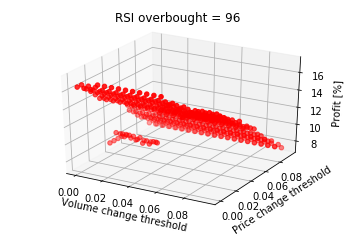

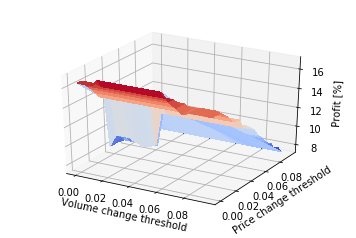

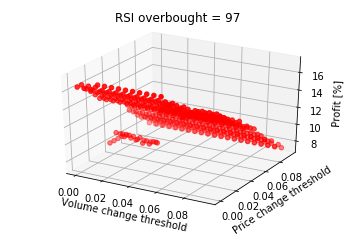

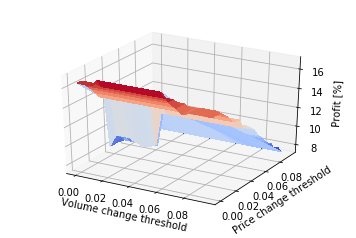

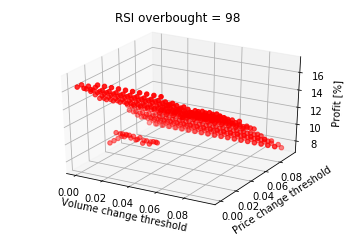

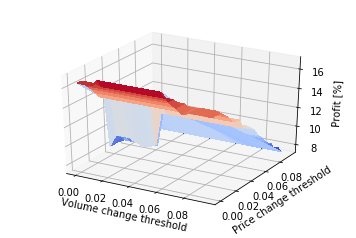

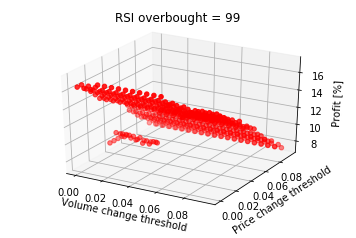

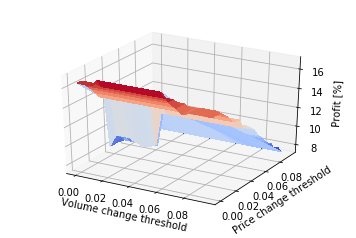

In [25]:
# Explore how RSI overbought influences the results
all_results = None
oversold_threshold = 20 # not used
for overbought_threshold in range(70,100):
    sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
    profit_df = calculate_profits(price_volume_df, start_cash, start_crypto, sell_strategy, **kwargs)
    profit_df['RSI overbought'] = pd.Series([overbought_threshold] * len(profit_df), index=profit_df.index)
    if all_results is None:
        all_results = profit_df
    else:
        all_results = all_results.append(profit_df, ignore_index=True)
    plot_profit_df(profit_df, "RSI overbought = {}".format(overbought_threshold))

In [26]:
all_results


,Volume change percent,Price change percent,Profit percent,RSI overbought
0,0.000,0.000,3.721297,70
1,0.000,0.005,7.983631,70
2,0.000,0.010,2.845531,70
3,0.000,0.015,5.637999,70
4,0.000,0.020,-5.566875,70
5,0.000,0.025,-0.127126,70
6,0.000,0.030,5.021356,70
7,0.000,0.035,-12.182607,70
8,0.000,0.040,-14.223728,70
9,0.000,0.045,-14.197139,70


In [28]:
sorted_by_profit = all_results.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent,RSI overbought
3021,0.055,0.005,29.291932,77
3821,0.055,0.005,28.891321,79
3421,0.055,0.005,28.891321,78
4220,0.055,0.000,26.717212,80
2841,0.010,0.005,26.422021,77
2861,0.015,0.005,26.317084,77
3241,0.010,0.005,26.030302,78
3641,0.010,0.005,26.030302,79
2881,0.020,0.005,26.000622,77
3661,0.015,0.005,25.925690,79


In [66]:
write_to_excel(all_results, "vbi_backtesting_btc_usdt.xlsx")

Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 77.0
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-04-01 22:42:39  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000144 BTC 	 (1 BTC = 6950.66486026 USDT )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-04-01 22:42:39 rsi_value=0
2018-04-12 13:00:00  	 OrderType.SELL   	 cash_balance ->          1.10 USDT 	 currency_balance ->     -0.000144 BTC 	 (1 BTC = 7704.91226307 USDT )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-12 13:00:00 rsi_value=84.3614320198976
2018-04-18 11:55:19  	 OrderType.BUY    	 cash_balance ->         -1.10 USDT 	 currency_balance ->      0.000136 BTC 	 (1 BTC = 8090.00000001 U

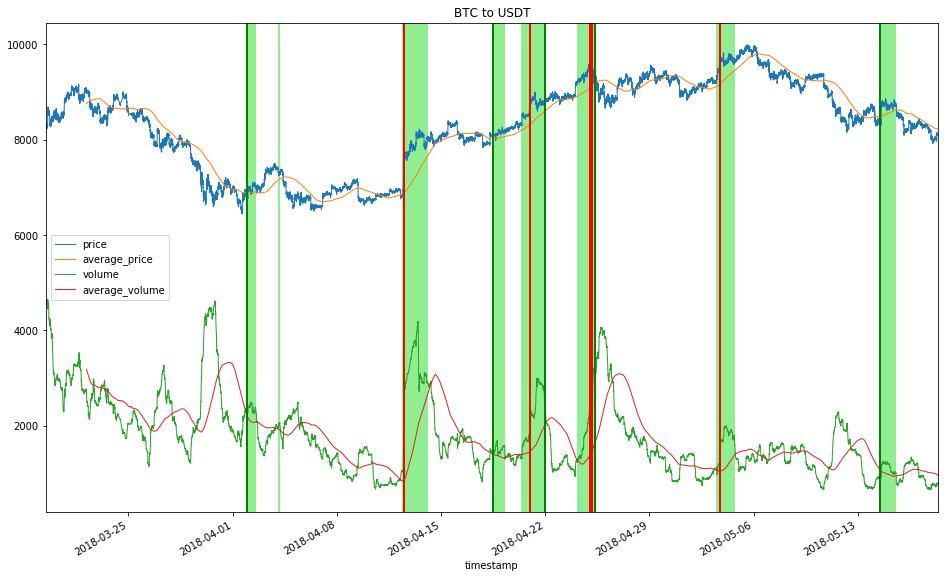

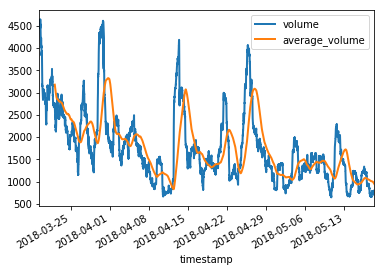

In [34]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]


sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, percent_change_price,
                                                                                percent_change_volume,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(1, start_crypto, start_time, end_time, verbose=True)

plot_results(price_volume_df, volumes_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)

In [30]:
# Let's establish the buy and hold and RSI baselines
from strategies import BuyAndHoldTimebasedStrategy
bah = BuyAndHoldTimebasedStrategy(start_time, end_time, transaction_currency, counter_currency, source)
bah.evaluate(start_cash, start_crypto, start_time, end_time)
rsi_strat = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                              75, 25, transaction_currency, "RSI", source)
rsi_strat.evaluate(start_cash, start_crypto, start_time, end_time)

--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-19 10:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 USDT 	 currency_balance ->      0.000122 BTC 	 (1 BTC = 8196.24900883 USDT )
2018-05-18 10:00:00  	 OrderType.SELL   	 cash_balance ->          0.98 USDT 	 currency_balance ->     -0.000122 BTC 	 (1 BTC = 8098.99000000 USDT )
End time: 2018-05-18 10:00:00

Summary
--
Number of trades: 2
End cash: 0.98 USDT
End crypto: 0.000000 BTC
Total value invested: 1 USDT
Total value after investment: 0.98 USDT (-1.68%)
Profit: -0.02 USDT
Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 75
  oversold_threshold = 25
  horizon = short
--

* Order execution log *

Start balance: cash = 1 USDT, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-26 13:00:00  	 OrderType.BUY    	 c